In [1]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

# === Utility: Rotate with bound to avoid clipping ===

def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = abs(M[0, 0])
    sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

# === Method 1: Manual Angle Calculation (Deskew via Hough Transform) ===

def deskew_manual(image, delta=1, limit=45):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    angles = np.arange(-limit, limit + delta, delta)
    scores = []
    for angle in angles:
        rot = rotate_bound(edges, angle)
        hist = np.sum(rot, axis=1)
        scores.append(np.sum((hist[1:] - hist[:-1])**2))
    best_angle = angles[np.argmax(scores)]
    deskewed = rotate_bound(image, best_angle)
    return deskewed, best_angle

# === Method 2: ML-based Angle Prediction (HOG + Random Forest) ===

def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image.copy()
    return hog(gray, orientations=9, pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=False)

class AngleRegressor:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)

    def generate_dataset(self, base_images, angles=np.linspace(-45, 45, 19)):
        X, y = [], []
        # assume all base_images have same shape
        h, w = base_images[0].shape[:2]
        for img in base_images:
            for ang in angles:
                rot = rotate_bound(img, ang)
                # resize back to original for consistent HOG length
                rot_fixed = cv2.resize(rot, (w, h), interpolation=cv2.INTER_LINEAR)
                feat = extract_hog_features(rot_fixed)
                X.append(feat)
                y.append(ang)
        return np.vstack(X), np.array(y)

    def train(self, X, y, test_size=0.2):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
        self.model.fit(X_train, y_train)
        score = self.model.score(X_val, y_val)
        print(f"Validation R² score: {score:.4f}")

    def predict_angle(self, image):
        # resize image to training size if needed
        feat = extract_hog_features(image)
        return self.model.predict([feat])[0]

    def deskew(self, image):
        angle = self.predict_angle(image)
        deskewed = rotate_bound(image, angle)
        return deskewed, angle

# === (Optional) Rotate only ROI to preserve surrounding image ===

def rotate_roi(image, bbox, angle):
    x, y, w, h = bbox
    roi = image[y:y+h, x:x+w]
    rot_roi = rotate_bound(roi, angle)
    result = image.copy()
    result[y:y+rot_roi.shape[0], x:x+rot_roi.shape[1]] = rot_roi
    return result

Validation R²: -0.6520


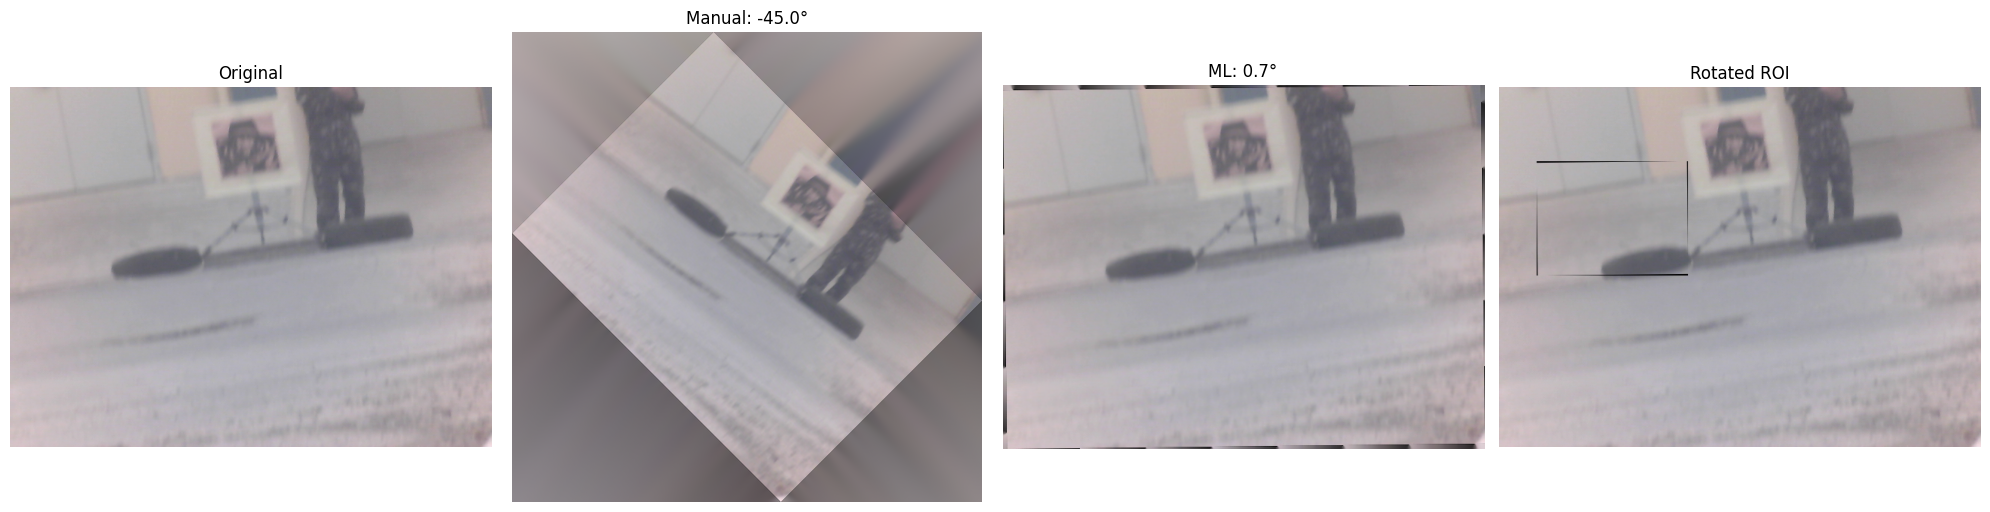

In [6]:
# === Example Usage in Jupyter Notebook ===
%matplotlib inline

# Load input image
img = cv2.imread('images/bo du lieu bia so 4/bia4 (2).bmp')  # Thay đường dẫn hoặc sử dụng cv2.imread với file của bạn

# Manual deskew full image
deskew_manual_img, ang1 = deskew_manual(img)

# ML deskew full image
generator = AngleRegressor()
X, y = generator.generate_dataset([img])  # now consistent shapes
generator.train(X, y)
deskew_ml_img, ang2 = generator.deskew(img)

# Rotate ROI example
bbox = [50, 100, 200, 150]
roi_rotated = rotate_roi(img, bbox, ang2)

# Display comparison
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, image_out, title in zip(axs,
                                [img, deskew_manual_img, deskew_ml_img, roi_rotated],
                                ['Original', f'Manual: {ang1:.1f}°', f'ML: {ang2:.1f}°', 'Rotated ROI']):
    ax.imshow(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Improve

In [3]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Utility: Rotate with options for transparency or interpolation fill ===

def rotate_bound(image, angle, mode="inpaint"):
    """
    Rotate image by angle without clipping, support fill modes.
    mode: "inpaint", "interpolate", or "transparent"
    """
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = abs(M[0, 0]); sin = abs(M[0, 1])
    nW = int((h * sin) + (w * cos)); nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX; M[1, 2] += (nH / 2) - cY

    if mode == "transparent":
        if image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
        rotated = cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0, 0))
        return rotated

    elif mode == "interpolate":
        return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    else:  # default inpaint mode with black border for later masking
        return cv2.warpAffine(image, M, (nW, nH), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))


def inpaint_borders(rotated):
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    mask = (gray == 0).astype(np.uint8) * 255
    return cv2.inpaint(rotated, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)


def rotate_and_fill(image, angle, mode="inpaint"):
    rot = rotate_bound(image, angle, mode)
    if mode == "inpaint":
        return inpaint_borders(rot)
    return rot

# === Method 1: Manual Deskew ===

def deskew_manual(image, delta=1, limit=45, mode="inpaint"):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    angles = np.arange(-limit, limit + delta, delta)
    scores = []
    for ang in angles:
        rot_edges = rotate_bound(edges, ang, mode="interpolate")
        hist = np.sum(rot_edges, axis=1)
        scores.append(np.sum((hist[1:] - hist[:-1])**2))
    best = angles[np.argmax(scores)]
    return rotate_and_fill(image, best, mode), best

# === Method 2: ML-based Deskew ===

def extract_hog_features(image, pixels_per_cell=(16,16), cells_per_block=(2,2)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(gray, orientations=9, pixels_per_cell=pixels_per_cell,
               cells_per_block=cells_per_block, block_norm='L2-Hys')

class AngleRegressor:
    def __init__(self, mode="inpaint"):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.mode = mode

    def generate_dataset(self, base_images, angles=np.linspace(-45,45,19)):
        X, y = [], []
        h, w = base_images[0].shape[:2]
        for img in base_images:
            for ang in angles:
                rot = rotate_and_fill(img, ang, self.mode)
                fixed = cv2.resize(rot, (w,h))
                X.append(extract_hog_features(fixed)); y.append(ang)
        return np.vstack(X), np.array(y)

    def train(self, X, y, test_size=0.2):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
        self.model.fit(X_train, y_train)
        print(f"Validation R²: {self.model.score(X_val, y_val):.4f}")

    def predict_angle(self, image):
        feat = extract_hog_features(image)
        return self.model.predict([feat])[0]

    def deskew(self, image):
        angle = self.predict_angle(image)
        return rotate_and_fill(image, angle, self.mode), angle

Validation R²: -0.5705


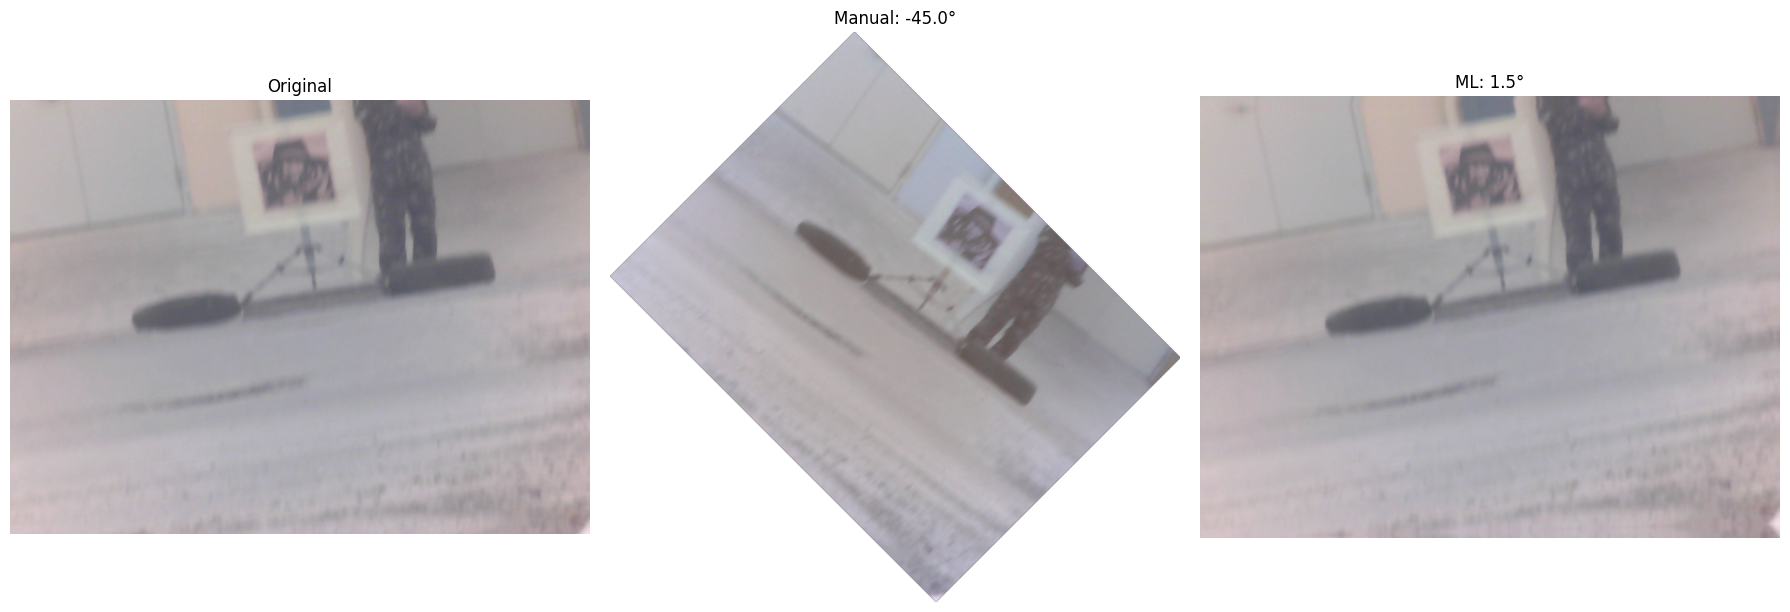

In [5]:
# === Example Notebook Usage ===
%matplotlib inline

# Load image
img = cv2.imread('images/bo du lieu bia so 4/bia4 (2).bmp')

# Manual deskew with transparency mode
deskew1, ang1 = deskew_manual(img, mode="transparent")

# ML deskew with interpolation fill
reg = AngleRegressor(mode="interpolate")
X, y = reg.generate_dataset([img]); reg.train(X, y)
deskew2, ang2 = reg.deskew(img)

fig, ax = plt.subplots(1, 3, figsize=(18,6))
for a, im, title in zip(ax, [img, deskew1, deskew2], ["Original", f"Manual: {ang1:.1f}°", f"ML: {ang2:.1f}°"]):
    a.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB) if im.shape[2]==3 else im)
    a.set_title(title); a.axis('off')
plt.tight_layout(); plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.transform import radon
from matplotlib import pyplot as plt
from ultralytics import YOLO

# 1. Hough-based deskew
def deskew_hough(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    lines = cv2.HoughLinesP(bw, 1, np.pi/180, threshold=100,
                            minLineLength=gray.shape[1]/4, maxLineGap=20)
    angles = [np.degrees(np.arctan2(y2-y1, x2-x1)) for x1,y1,x2,y2 in lines[:,0]]
    angle = np.median(angles)
    M = cv2.getRotationMatrix2D((gray.shape[1]/2, gray.shape[0]/2), angle, 1.0)
    return cv2.warpAffine(image, M, (gray.shape[1], gray.shape[0]))

# 2. Radon-based deskew
def deskew_radon(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # resize small for speed
    small = cv2.resize(gray, (256, 256))
    sinogram = radon(small)
    # sum of projections for each angle
    sums = np.sum(sinogram, axis=0)
    angle = np.argmax(sums) - 90
    M = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, 1.0)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

# 3. PCA-based deskew
def deskew_pca(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    ys, xs = np.nonzero(edges)
    data = np.vstack([xs, ys]).T
    mean = np.mean(data, axis=0)
    centered = data - mean
    cov = np.cov(centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    principal = eigvecs[:, np.argmax(eigvals)]
    angle = np.degrees(np.arctan2(principal[1], principal[0]))
    M = cv2.getRotationMatrix2D(tuple(mean[::-1]), angle, 1.0)
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

# 4. Fourier-based deskew (magnitude spectrum + Hough)
def deskew_fourier(image):
    # 1. Chuyển sang grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 2. FFT và magnitude phổ
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude = np.log1p(np.abs(fshift))
    # 3. Tìm biên trên phổ
    edges = cv2.Canny(np.uint8(magnitude), 50, 150)
    # 4. Hough Transform trên phổ
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=80)
    
    # 5. Xử lý khi không có line
    if lines is None:
        # fallback: giữ nguyên ảnh nếu không phát hiện được đường
        angle = 0.0
    else:
        # Lấy góc trung bình (radian → độ, shift -90°)
        thetas = [l[0][1] for l in lines]
        angles_deg = [theta * 180/np.pi - 90 for theta in thetas]
        angle = np.median(angles_deg)
    
    # 6. Xoay ảnh ngược lại
    (h, w) = gray.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    deskewed = cv2.warpAffine(image, M, (w, h))
    return deskewed

def deskew_yolo(image, model_path='yolo-models/yolo11n-obb.pt'):
    model = YOLO(model_path).to('cpu')
    res = model.predict(source=image)[0]
    if len(res.obb.xywhr)==0: return image
    x,y,w,h,angle = res.obb.xywhr[0]
    M = cv2.getRotationMatrix2D((image.shape[1]/2,image.shape[0]/2), angle,1.0)
    return cv2.warpAffine(image, M, (image.shape[1],image.shape[0]))

# Load image
img = cv2.imread('images/bo du lieu bia so 4/bia4 (2).bmp')

# Apply methods
results = {
    'Original': img,
    'Hough': deskew_hough(img),
    'Radon': deskew_radon(img),
    'PCA': deskew_pca(img),
    'Fourier': deskew_fourier(img),
    'YOLO-OBB': deskew_yolo(img)
}
# Hiển thị
fig, axes = plt.subplots(1,len(results),figsize=(18,4))
for ax,(t,im) in zip(axes,results.items()):
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.set_title(t)
    ax.axis('off')
plt.tight_layout()
plt.show()

AttributeError: partially initialized module 'torch' from 'c:\Users\cuong\workspace\ml-tools\cicle-detector\.venv\Lib\site-packages\torch\__init__.py' has no attribute 'fx' (most likely due to a circular import)

: 